<a href="https://colab.research.google.com/github/sagarikajadon13/Grammar-Error-Detection/blob/main/0_EDA%2C_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

import spacy
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
train= pd.read_csv('/content/drive/MyDrive/SHL NLP task/train_data.csv')
val= pd.read_csv('/content/drive/MyDrive/SHL NLP task/val_data.csv')
test= pd.read_csv('/content/drive/MyDrive/SHL NLP task/test_data.csv')
test_inputs= test['input']

0-> grammatically incorrect

1-> correct

In [ ]:
train

,input,labels
0,I am reading score of Mahler is Symphony No . .,0
1,I am not interested in cars or electric applia...,1
2,This is my homework for my English class .,0
3,"In comparison , Canada is catches increased an...",0
4,"Fortunately , my older sister is friend is a d...",1
...,...,...
19993,More than a hundred thousand people are suppor...,1
19994,The reason why we chose this subject a few day...,1
19995,When you buy CBS is Criminal Minds DVD in Japa...,1
19996,but it is dizzying for me T T,1


In [ ]:
val

,input,labels
0,It was the same thing .,0
1,I can study idioms a lot,1
2,I just bet some coins for numbers or colors .,0
3,"Yesterday , I was checking some e - mails on b...",1
4,I regret that I have not played the piano very...,1
...,...,...
9995,"Actually , I started college this April even t...",1
9996,I am sure we all get more sophisticated as we ...,1
9997,I am worried about my English lessons and the ...,1
9998,It is okay to change the meaning though .,0


In [ ]:
test

,input
0,I believe they will master Japanese soon becau...
1,I am looking for it .
2,Apple is a round fruit with smooth and colorfu...
3,Let It Will Be Push .
4,I rode on this ship from Sendai .
...,...
9967,Lang is growing up and improving step by step !
9968,I was away from my housework for about days .
9969,The conflict is so serious .
9970,An apple is a round fruit with smooth and colo...


In [ ]:
train['labels'].describe()

count    19998.000000
mean         0.500000
std          0.500013
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: labels, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


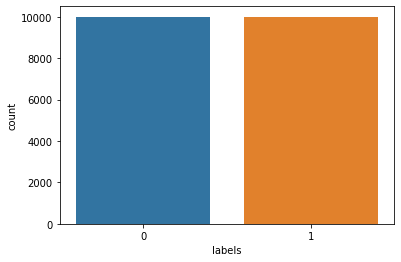

In [ ]:
sns.countplot(train['labels'])

The training data labels are balanced.

In [ ]:
train.isnull().sum()

input     0
labels    0
dtype: int64

In [ ]:
train['input_len']= train['input'].apply(lambda x: len(x.split(' ')))

In [ ]:
train['input_len'].describe()

count    19998.000000
mean        11.725423
std          7.633283
min          2.000000
25%          7.000000
50%         10.000000
75%         15.000000
max        319.000000
Name: input_len, dtype: float64

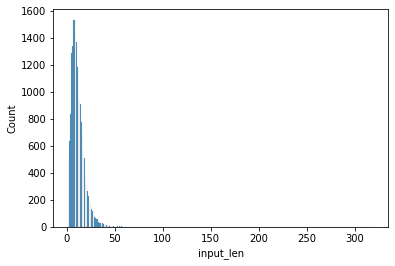

In [ ]:
sns.histplot(train['input_len'])

In [ ]:
train[train['input_len']== 319]

,input,labels,input_len
19598,Corporate Governance To check whether the meet...,0,319


In [ ]:
train.loc[19598].input

'Corporate Governance To check whether the meeting records of the Board of Directors and Special Committee were complete and signed by directors who attended the meetings . To check the contents , deadline and signatures of the formal written authorization of shareholder representatives . To check whether scopes of authority were written in letters of authorization by the directors , the letters were signed by directors and the meeting records took down the trustees who attended the meetings . To read all the formal written meeting records and to check whether the frequency of arranging the Board meetings complies with articles of incorporation . To check the meeting records , resolutions and other related contents of Board of Supervisors and to check whether the frequency of arranging the meeting complies with articles of incorporation . To check the meeting records , resolutions and other related contents of the three Special Committees and whether the frequency of arranging the comm

In [ ]:
text_319= train.loc[19598].input

In [ ]:
text_319= text_319.split(' . ')

In [ ]:
text_319

['Corporate Governance To check whether the meeting records of the Board of Directors and Special Committee were complete and signed by directors who attended the meetings',
 'To check the contents , deadline and signatures of the formal written authorization of shareholder representatives',
 'To check whether scopes of authority were written in letters of authorization by the directors , the letters were signed by directors and the meeting records took down the trustees who attended the meetings',
 'To read all the formal written meeting records and to check whether the frequency of arranging the Board meetings complies with articles of incorporation',
 'To check the meeting records , resolutions and other related contents of Board of Supervisors and to check whether the frequency of arranging the meeting complies with articles of incorporation',
 'To check the meeting records , resolutions and other related contents of the three Special Committees and whether the frequency of arrangi

In [ ]:
df= pd.DataFrame({'input': text_319,
                  'labels': [1]* len(text_319)})

In [ ]:
df

,input,labels
0,Corporate Governance To check whether the meet...,1
1,"To check the contents , deadline and signature...",1
2,To check whether scopes of authority were writ...,1
3,To read all the formal written meeting records...,1
4,"To check the meeting records , resolutions and...",1
5,"To check the meeting records , resolutions and...",1
6,To check the reports of independent directors ...,1
7,To read all meeting records of the Board of Di...,1
8,To read all the formal written meeting records...,1
9,To check whether the written notices comply wi...,1


In [ ]:
train= train.append(df, ignore_index= True)

In [ ]:
train.tail(20)

,input,labels,input_len
19991,He turned years old the day before yesterday .,1,9.0
19992,"He has two little children , and he just bough...",1,16.0
19993,More than a hundred thousand people are suppor...,1,11.0
19994,The reason why we chose this subject a few day...,1,29.0
19995,When you buy CBS is Criminal Minds DVD in Japa...,1,18.0
19996,but it is dizzying for me T T,1,8.0
19997,in several times .,0,4.0
19998,Corporate Governance To check whether the meet...,1,NaN
19999,"To check the contents , deadline and signature...",1,NaN
20000,To check whether scopes of authority were writ...,1,NaN


In [ ]:
train= train.drop(19598, axis= 0).reset_index(drop= True)

In [ ]:
train

,input,labels,input_len
0,I am reading score of Mahler is Symphony No . .,0,11.0
1,I am not interested in cars or electric applia...,1,10.0
2,This is my homework for my English class .,0,9.0
3,"In comparison , Canada is catches increased an...",0,18.0
4,"Fortunately , my older sister is friend is a d...",1,11.0
...,...,...,...
20005,To read all the formal written meeting records...,1,NaN
20006,To check whether the written notices comply wi...,1,NaN
20007,To check the rules of procedure and reports of...,1,NaN
20008,To check whether the supervisors are in charge...,1,NaN


In [ ]:
train['input_len']= train['input'].apply(lambda x: len(x.split(' ')))

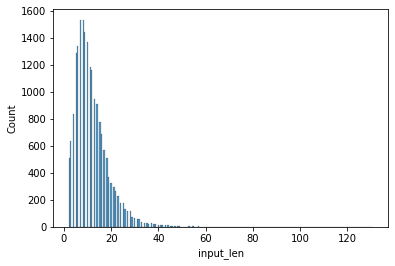

In [ ]:
sns.histplot(train['input_len'])

In [ ]:
stop_words= stopwords.words('english')
# stemmer= SnowballStemmer('english')
lemmatizer= WordNetLemmatizer()

def preprocess_data(text):
  # text= ' '.join(word for word in text.split(' ') if word not in stop_words)
  # text= ' '.join(stemmer.stem(word) for word in text.split(' '))
  text= ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
  return text

In [ ]:
train['preprocessed']= train['input'].apply(preprocess_data)
val['preprocessed']= val['input'].apply(preprocess_data)

In [ ]:
train

,input,labels,input_len,preprocessed
0,I am reading score of Mahler is Symphony No . .,0,11,I am reading score of Mahler is Symphony No . .
1,I am not interested in cars or electric applia...,1,10,I am not interested in car or electric applian...
2,This is my homework for my English class .,0,9,This is my homework for my English class .
3,"In comparison , Canada is catches increased an...",0,18,"In comparison , Canada is catch increased and ..."
4,"Fortunately , my older sister is friend is a d...",1,11,"Fortunately , my older sister is friend is a d..."
...,...,...,...,...
20005,To read all the formal written meeting records...,1,25,To read all the formal written meeting record ...
20006,To check whether the written notices comply wi...,1,15,To check whether the written notice comply wit...
20007,To check the rules of procedure and reports of...,1,13,To check the rule of procedure and report of t...
20008,To check whether the supervisors are in charge...,1,18,To check whether the supervisor are in charge ...


In [ ]:
to_drop= (train.loc[train['input']== ' '])

In [ ]:
to_drop.index

Int64Index([  254,   259,   512,   629,  1033,  1129,  1529,  2149,  2558,
             2879,  2938,  3537,  3714,  3958,  4046,  4068,  4083,  4153,
             4399,  4493,  5128,  5165,  5318,  5622,  5976,  6021,  6313,
             6317,  6470,  6986,  7003,  7216,  7585,  7779,  7879,  8013,
             8136,  8416,  8748,  9058,  9122,  9733,  9872, 10619, 11027,
            11762, 11923, 11971, 12334, 12564, 12611, 12869, 12906, 13053,
            13326, 14287, 14292, 14308, 14773, 14836, 15260, 15407, 15744,
            15827, 15864, 15959, 16912, 17040, 17696, 17786, 18428, 18611,
            19176, 19376, 19882],
           dtype='int64')

In [ ]:
train= train.drop(to_drop.index, axis= 0).reset_index(drop= True)

In [ ]:
train.to_csv('train_processed.csv', index= False)